In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("../src")
import exlib
from exlib.datasets.cholecystectomy import CholecDataset, CholecModel, CholecMetric

## Overview
* The objective is to predict the **go/nogo** regions (safe, unsafe).
* The higher-level features are the **organs** (liver, gallblader, and hepatocystic triangle).

## Load datasets and pre-trained models

In [2]:
dataset = CholecDataset(split="all_data")
gonogo_model = CholecModel.from_pretrained("BrachioLab/cholecystectomy_gonogo").eval()
organs_model = CholecModel.from_pretrained("BrachioLab/cholecystectomy_organs").eval()

## Dataset samples and model predictions

In [3]:
sample = dataset[7] # Lucky number
image, gonogo, organs = sample["image"], sample["gonogo"], sample["organs"]
with torch.no_grad():
    gonogo_pred = gonogo_model(image[None,...]).logits[0].argmax(dim=0)
    organs_pred = organs_model(image[None,...]).logits[0].argmax(dim=0)

## True labels vs pre-trained model predictions

<Figure size 640x480 with 0 Axes>

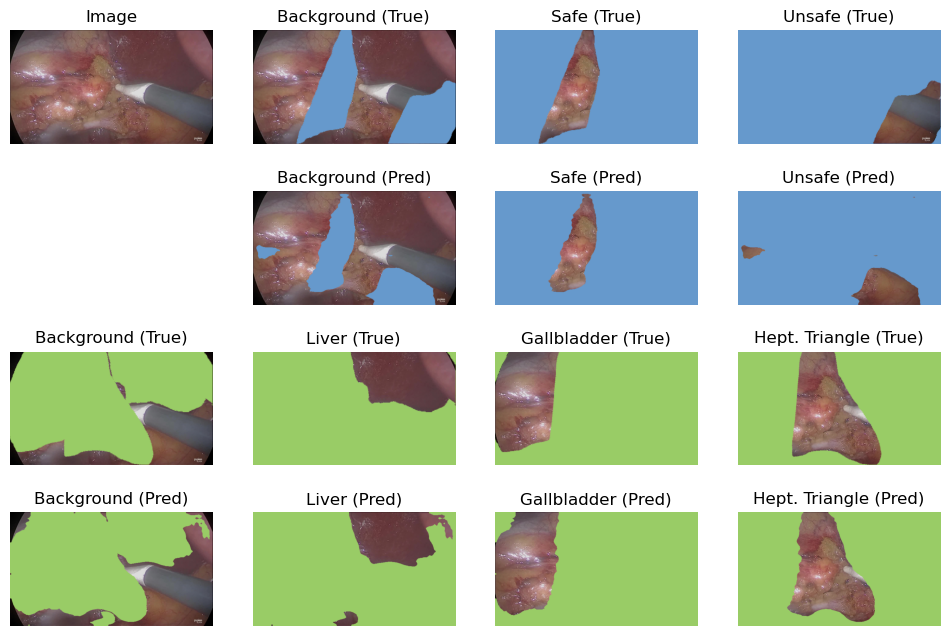

In [4]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "gng_t0", "gng_t1", "gng_t2"],
    [".", "gng_p0", "gng_p1", "gng_p2"],
    ["org_t0", "org_t1", "org_t2", "org_t3"],
    ["org_p0", "org_p1", "org_p2", "org_p3"],
], figsize=(12,8))

for _, a in ax.items(): a.set_axis_off()
gng_titles = ["Background", "Safe", "Unsafe"]
org_titles = ["Background", "Liver", "Gallbladder", "Hept. Triangle"]
C1 = torch.tensor([0.4, 0.6, 0.8]).view(3,1,1)
C2 = torch.tensor([0.6, 0.8, 0.4]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(3):
    mask_t = (gonogo == i).unsqueeze(0)
    mask_p = (gonogo_pred == i).unsqueeze(0)
    ax[f"gng_t{i}"].imshow(((image * mask_t) + (~mask_t * C1)).numpy().transpose(1,2,0))
    ax[f"gng_p{i}"].imshow(((image * mask_p) + (~mask_p * C1)).numpy().transpose(1,2,0))
    ax[f"gng_t{i}"].set_title(f"{gng_titles[i]} (True)")
    ax[f"gng_p{i}"].set_title(f"{gng_titles[i]} (Pred)")

for i in range(4):
    mask_t = (organs == i).unsqueeze(0)
    mask_p = (organs_pred == i).unsqueeze(0)
    ax[f"org_t{i}"].imshow(((image * mask_t) + (~mask_t * C2)).numpy().transpose(1,2,0))
    ax[f"org_p{i}"].imshow(((image * mask_p) + (~mask_p * C2)).numpy().transpose(1,2,0))
    ax[f"org_t{i}"].set_title(f"{org_titles[i]} (True)")
    ax[f"org_p{i}"].set_title(f"{org_titles[i]} (Pred)")

## How well are the higher-level feature alignments?
Let's first define another simple grid-based higher-level feature model

In [5]:
class GridHighLevelFeatures(nn.Module):
    # Let's assume image is 360x640 and make 40x40 grids (i.e., 9x16 partitions)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        N, _, _, _ = x.shape
        mask_small = torch.tensor(range(9*16)).view(1,1,9,16).repeat(N,1,1,1)
        mask_big = F.interpolate(mask_small.float(), scale_factor=40).round().long()
        return mask_big.view(N,360,640)

## Now let's compare the pretrained model vs the grid feature

In [6]:
metric = CholecMetric()
grid_model = GridHighLevelFeatures()
torch.manual_seed(1234)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
pretrained_scores, grid_scores = [], []
for i, item in enumerate(tqdm(dataloader)):
    image = item["image"]
    with torch.no_grad():
        organs_true_masks = F.one_hot(item["organs"]).permute(0,3,1,2)
        pretrained_masks = F.one_hot(organs_model(image).logits.argmax(dim=1)).permute(0,3,1,2)
        grid_masks = F.one_hot(grid_model(image)).permute(0,3,1,2)
        pretrained_score = metric(pretrained_masks, organs_true_masks) # (N,H,W)
        grid_score = metric(grid_masks, organs_true_masks) # (N,H,W)

        pretrained_scores.append(pretrained_score.mean(dim=(1,2)))
        grid_scores.append(grid_score.mean(dim=(1,2)))
        
    if i > 20:
        break

pretrained_scores = torch.cat(pretrained_scores)
grid_scores = torch.cat(grid_scores)

print(f"Avg alignment of pretrained model: {pretrained_scores.mean():.4f}")
print(f"Avg alignment of grid model: {grid_scores.mean():.4f}")

  8%|▊         | 21/254 [02:03<22:54,  5.90s/it]

Avg alignment of pretrained model: 0.7479
Avg alignment of grid model: 0.0252
